<a href="https://colab.research.google.com/github/rohinish404/learning_pytorch/blob/master/pytorch_classification_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import sklearn

In [152]:
from sklearn.datasets import make_circles
n_samples = 1000
X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

In [153]:
len(X)

1000

In [154]:
X[:10]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343],
       [-0.47964637,  0.67643477],
       [-0.01364836,  0.80334872],
       [ 0.77151327,  0.14775959],
       [-0.16932234, -0.79345575],
       [-0.1214858 ,  1.02150905]])

In [155]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [156]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label":y})

In [157]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


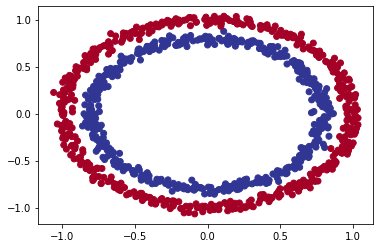

In [158]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y= X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [159]:
import torch 
torch.__version__

'1.13.1+cu116'

In [160]:
type(X)

numpy.ndarray

In [161]:
X = torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [162]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [163]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

In [164]:
len(X_train)

800

In [165]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [166]:
from sklearn import datasets

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2,out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5,out_features = 1)


  def forward(self,x):
    return self.layer_2(self.layer_1(x)) 


model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [167]:
device

'cuda'

In [168]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [169]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [170]:
untrained_preds = model_0(X_test.to(device))

In [171]:
len(untrained_preds)

200

In [172]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [173]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc


In [174]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits  

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [175]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [176]:
y_preds = torch.round(y_preds_probs)

In [177]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train.to(device)).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))


    test_loss =  loss_fn(test_logits,y_test)
    test_acc =  accuracy_fn(y_true = y_test,
                    y_pred = test_pred)
    

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")    

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.88% | Test loss: 0.69262, Test acc: 53.00%


In [178]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


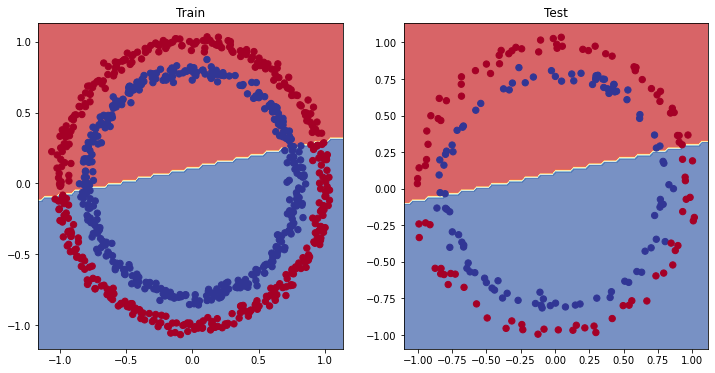

In [179]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)

In [180]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2,out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10,out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10,out_features = 1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))



model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [181]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.1)

In [182]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 1000

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)


for epoch in range(epochs):
      model_1.train()

      y_logits =  model_1(X_train).squeeze()
      y_pred = torch.round(torch.sigmoid(y_logits))

      loss = loss_fn(y_logits,y_train)

      acc = accuracy_fn(y_true = y_train,
                        y_pred = y_pred)
      
      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      model_1.eval()
      with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))


        test_loss =  loss_fn(test_logits,y_test)
        test_acc =  accuracy_fn(y_true = y_test,
                        y_pred = test_pred)
        

      if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


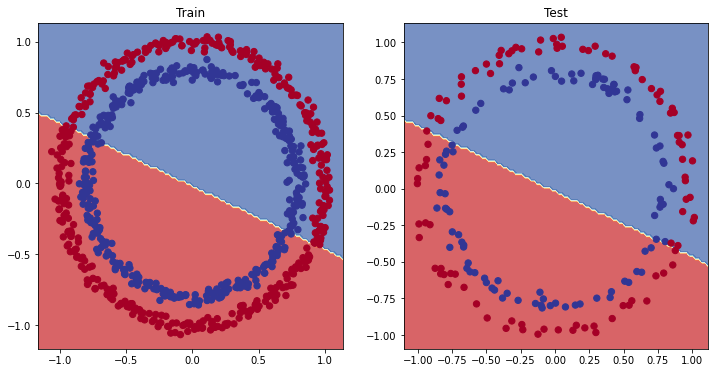

In [183]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,y_test)

In [184]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

len(X_regression)

100

In [185]:
train_split = int(0.8*len(X_regression))
X_train_regression,y_train_regression = X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression = X_regression[train_split:],y_regression[train_split:]
len(X_train_regression),len(X_test_regression),len(y_train_regression),len(y_test_regression)

(80, 20, 80, 20)

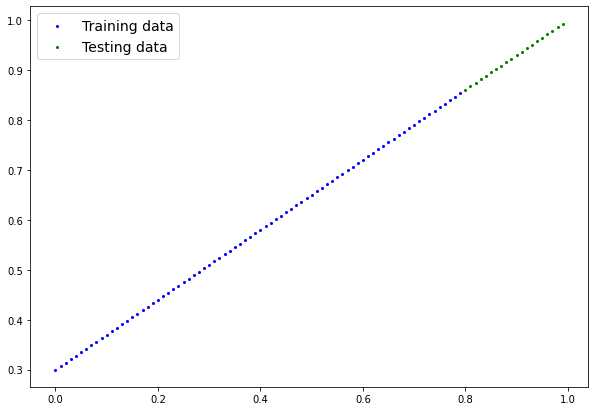

In [186]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [187]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [188]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr=0.01)

In [189]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


epochs = 1000

X_train_regression,y_train_regression = X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device),y_test_regression.to(device)


for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred,y_test_regression)


  if epoch % 100==0:
    print(f"Epoch: {epoch} | Loss:{loss:.5f} | Test_loss: {test_loss:.5f}")

Epoch: 0 | Loss:0.75986 | Test_loss: 0.91103
Epoch: 100 | Loss:0.02858 | Test_loss: 0.00081
Epoch: 200 | Loss:0.02533 | Test_loss: 0.00209
Epoch: 300 | Loss:0.02137 | Test_loss: 0.00305
Epoch: 400 | Loss:0.01964 | Test_loss: 0.00341
Epoch: 500 | Loss:0.01940 | Test_loss: 0.00387
Epoch: 600 | Loss:0.01903 | Test_loss: 0.00379
Epoch: 700 | Loss:0.01878 | Test_loss: 0.00381
Epoch: 800 | Loss:0.01840 | Test_loss: 0.00329
Epoch: 900 | Loss:0.01798 | Test_loss: 0.00360


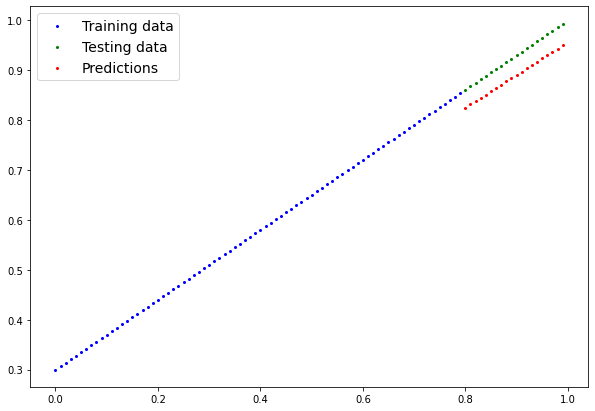

In [190]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)


plot_predictions(train_data=X_train_regression.cpu(),
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions = y_preds.cpu()
);  

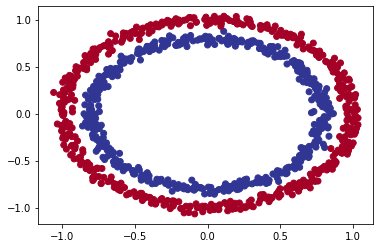

In [191]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X,y = make_circles(n_samples,noise=0.03,random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [192]:
import torch
from sklearn.model_selection import train_test_split

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)



In [193]:

from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):

       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [194]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

In [195]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

epochs = 1000
for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  
  optimizer.zero_grad()
  
  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))


      test_loss = loss_fn(test_logits,y_test)

      test_acc = accuracy_fn(y_true = y_test,
                    y_pred = test_pred)
      

  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")   

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00


In [196]:
model_3.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.6760,  0.8035],
                      [-0.1997,  0.7568],
                      [-0.1549,  0.1427],
                      [-0.9637,  0.2292],
                      [ 0.5717, -1.3426],
                      [ 0.6689,  0.1840],
                      [ 0.7970,  0.2595],
                      [ 0.3410, -0.0998],
                      [ 0.6555,  0.3186],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3761, -0.2008, -0.2872,  0.2803, -0.4513, -0.3364, -0.3300, -0.4252,
                      -0.1989, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 1.3081e-01, -3.7347e-01,  2.4414e-01, -4.3348e-02, -2.7270e-01,
                        1.0512e-01, -4.7109e-02,  2.5550e-01, -4.9248e-02, -9.9730e-02],
                      [ 7.9469e-01,  3.8277e-01,  1.3309e-01,  7.5399e-01,  9.7241e-01,
                        2.6996e-01,  6.2185e-01,  5.6581e-02,

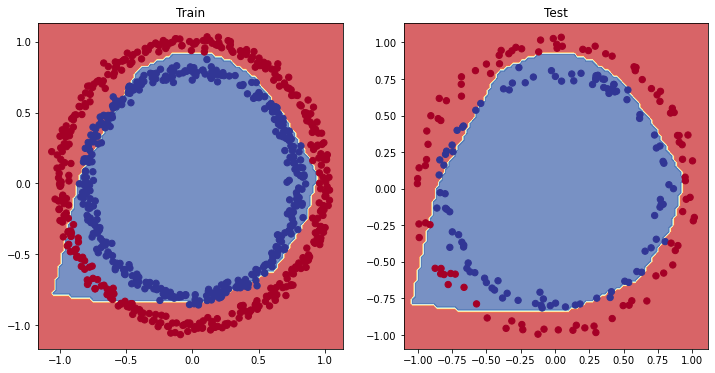

In [197]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3,X_test,y_test)

In [198]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [199]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob,y_blob = make_blobs(n_samples = 1000,
                           n_features = NUM_FEATURES,
                           centers = NUM_CLASSES,
                           random_state = RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


X_blob_train,X_blob_test, y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

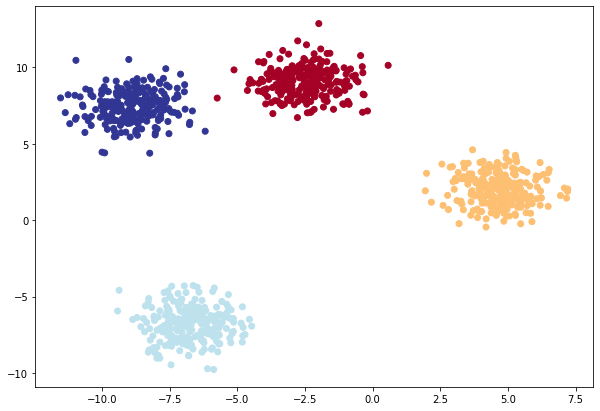

In [200]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [201]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [202]:
class BlobModel(nn.Module):
   def __init__(self,input_features,output_features,hidden_units = 8):
     super().__init__()

     self.linear_layer_stack = nn.Sequential(
         nn.Linear(in_features=input_features,out_features = hidden_units),
        #  nn.reLu()
         nn.Linear(in_features=hidden_units,out_features = hidden_units),
        #  nn.reLu()
         nn.Linear(in_features=hidden_units,out_features = output_features)
     )

   def forward(self,x):
    return self.linear_layer_stack(x)


model_4 =  BlobModel(input_features=2,output_features=4,hidden_units = 8).to(device)
model_4   

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [203]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)

In [204]:
model_4(X_blob_test.to(device))[:5]

tensor([[-1.1988, -0.6983, -1.4013, -0.6101],
        [ 1.7765, -1.2490,  1.7994,  2.1650],
        [ 2.2684,  0.7261,  2.6267,  1.0674],
        [-0.8950, -0.4057, -1.0242, -0.5896],
        [-0.2137, -1.5658, -0.4405,  0.8248]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [205]:
y_logits = model_4(X_blob_test.to(device))
y_blobs_preds = torch.softmax(y_logits,dim=1)
print(y_blobs_preds[:5])

tensor([[0.1898, 0.3131, 0.1550, 0.3420],
        [0.2820, 0.0137, 0.2885, 0.4158],
        [0.3395, 0.0726, 0.4858, 0.1021],
        [0.2055, 0.3351, 0.1806, 0.2789],
        [0.2049, 0.0530, 0.1633, 0.5788]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [206]:
print(torch.argmax(y_blobs_preds[0]))


tensor(3, device='cuda:0')


In [207]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)

  accuracy = accuracy_fn(y_true = y_blob_train,
                         y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)

    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                         y_pred = test_preds)
    

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}")   

Epoch: 0 | Loss: 1.03702, Accuracy: 87.62% | Test Loss: 0.56405, Test Accuracy: 99.00
Epoch: 10 | Loss: 0.11087, Accuracy: 87.62% | Test Loss: 0.10004, Test Accuracy: 100.00
Epoch: 20 | Loss: 0.04924, Accuracy: 87.62% | Test Loss: 0.04515, Test Accuracy: 100.00
Epoch: 30 | Loss: 0.03032, Accuracy: 87.62% | Test Loss: 0.02747, Test Accuracy: 100.00
Epoch: 40 | Loss: 0.02171, Accuracy: 87.62% | Test Loss: 0.01930, Test Accuracy: 100.00
Epoch: 50 | Loss: 0.01691, Accuracy: 87.62% | Test Loss: 0.01471, Test Accuracy: 100.00
Epoch: 60 | Loss: 0.01389, Accuracy: 87.62% | Test Loss: 0.01182, Test Accuracy: 100.00
Epoch: 70 | Loss: 0.01182, Accuracy: 87.62% | Test Loss: 0.00985, Test Accuracy: 100.00
Epoch: 80 | Loss: 0.01033, Accuracy: 87.62% | Test Loss: 0.00843, Test Accuracy: 100.00
Epoch: 90 | Loss: 0.00920, Accuracy: 87.62% | Test Loss: 0.00736, Test Accuracy: 100.00


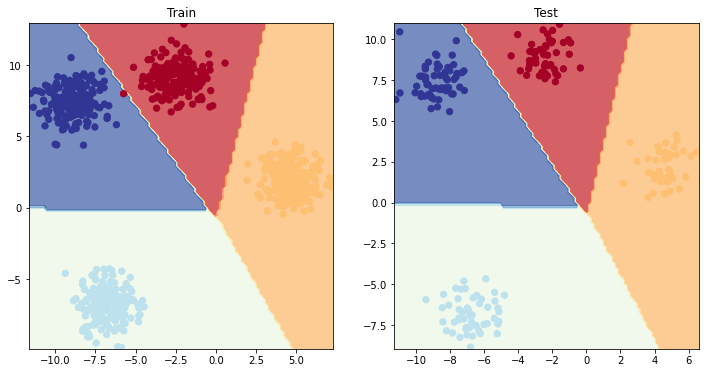

In [208]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

In [212]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to("cpu"))

y_logits[:10]

tensor([[  3.7826,   9.6491, -13.3450,  -9.3730],
        [  4.6158, -11.4566,   3.4186,  10.4919],
        [ -5.3788, -13.3182,  20.4722,  13.1327],
        [  2.1570,   7.7691,  -9.2223,  -7.4535],
        [  7.4186,   2.1213, -12.5309,  -2.5824],
        [  4.9372, -13.2517,   4.4570,  12.1594],
        [ -5.5794, -11.3640,  19.1111,  11.3043],
        [  6.7285,  -0.4670,  -9.2495,  -0.0764],
        [ -5.4545, -16.6079,  23.4032,  16.2471],
        [  6.9009,   0.4720, -10.3194,  -0.9787]])

In [213]:
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[2.8248e-03, 9.9718e-01, 1.0293e-10, 5.4652e-09],
        [2.7957e-03, 2.9264e-10, 8.4440e-04, 9.9636e-01],
        [5.9257e-12, 2.1121e-15, 9.9935e-01, 6.4892e-04],
        [3.6402e-03, 9.9636e-01, 4.1605e-08, 2.4398e-07],
        [9.9498e-01, 4.9797e-03, 2.1569e-09, 4.5125e-05],
        [7.2934e-04, 9.1959e-12, 4.5122e-04, 9.9882e-01],
        [1.8918e-11, 5.8164e-14, 9.9959e-01, 4.0681e-04],
        [9.9815e-01, 7.4855e-04, 1.1482e-07, 1.1062e-03],
        [2.9304e-13, 4.1984e-18, 9.9922e-01, 7.7953e-04],
        [9.9801e-01, 1.6110e-03, 3.3149e-08, 3.7764e-04]])

In [210]:
for name, param in model_4.named_parameters():
    print(name, param.device)

linear_layer_stack.0.weight cpu
linear_layer_stack.0.bias cpu
linear_layer_stack.1.weight cpu
linear_layer_stack.1.bias cpu
linear_layer_stack.2.weight cpu
linear_layer_stack.2.bias cpu


In [214]:
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])